In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import statistics
import random
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_DIR = '/content/drive/MyDrive/Mid/CIFAR-10-images-master/test'
IMG_SIZE = 32
CATEGORIES = [i for i in os.listdir(DATA_DIR)]

print(CATEGORIES)

['ship', 'airplane', 'deer', 'bird', 'horse', 'truck', 'cat', 'dog', 'frog', 'automobile']


In [ ]:
training_data = []

for c in CATEGORIES:
    path = os.path.join(DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   # read the image
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize the image
            img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
            training_data.append([img_gray, class_num])
        except:
            pass

print(len(training_data))

100%|██████████| 1000/1000 [00:18<00:00, 53.17it/s]

10000


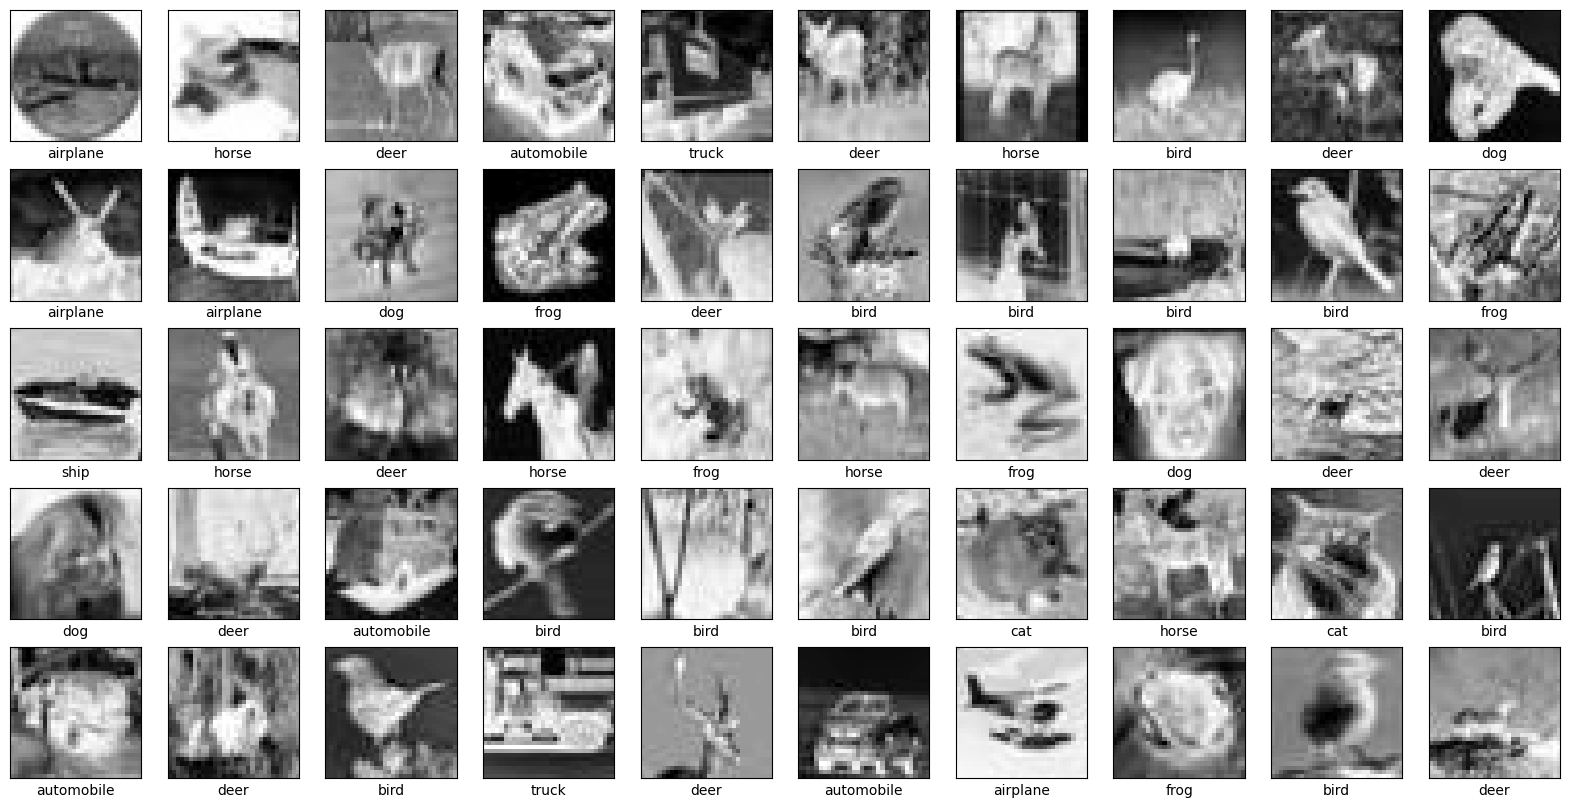

In [ ]:
random.shuffle(training_data)
plt.figure(figsize=(20,10))

for i in range(50):
    plt.subplot(5,10,i+1)
    plt.imshow(training_data[i][0], cmap='gray_r')
    plt.xlabel(CATEGORIES[training_data[i][1]])
    plt.xticks([])
    plt.yticks([])
    if i==50:
        break
plt.show()


In [ ]:
f1 = training_data[0:2000]
f2 = training_data[2000:4000]
f3 = training_data[4000:6000]
f4 = training_data[6000:8000]
f5 = training_data[8000:10000]
folds = [f1, f2, f3, f4, f5]

In [ ]:
def manhattan_distance(img1, img2):
    return np.sum(np.abs(img1 - img2))


def euclidian_distance(img1, img2):
    return np.sqrt(np.sum((img1 - img2) ** 2))


def normalize(data):
    return [[np.round(img_array / 255, 3), class_num] for [img_array, class_num] in data]


def by_l1_dist(list):
    return list[2]["l1"]


def by_l2_dist(list):
    return list[2]["l2"]

In [ ]:
top_filter = 20


def cal_dist(train_fold, valid_fold):
    l1_result = []
    l2_result = []
    for valid in tqdm(valid_fold):  # valid = [img_resized, class_num]
        temp_dist_list = []
        for train in train_fold:    # train = [img_resized, class_num]
            l1_dist = manhattan_distance(valid[0], train[0])
            l2_dist = euclidian_distance(valid[0], train[0])
            temp_dist_list.append([valid[1],  train[1], {"l1": l1_dist, "l2": l2_dist}])
        # sort by L1
        temp_dist_list.sort(key=by_l1_dist)
        l1_result.append(temp_dist_list[:top_filter])
        # sort by L2
        temp_dist_list.sort(key=by_l2_dist)
        l2_result.append(temp_dist_list[:top_filter])
    return [l1_result, l2_result]

In [ ]:
k_range = 20
def cal_accuracy(dist_result, dist_term):
    k_accuracies = []  # k_range values
    for k in range(1, k_range+1):
        img_accuracy = 0
        for valid_img in dist_result:
            nn = valid_img[:k]
            same_class = [n for n in nn if n[0] == n[1]]
            same_class_len = len(same_class)
            if k % 2 != 0:                      # k is ODD
                if ((k-1) / 2) < same_class_len:  # majority has same class
                    img_accuracy += 1
            else:                                   # k is EVEN
                diff_class = [n for n in nn if n[0] != n[1]]
                if same_class_len > len(diff_class):    # majority has same class
                    img_accuracy += 1
                elif same_class_len == len(diff_class): # tie
                    same_class_dist = sum([n[2][dist_term] for n in same_class])
                    diff_class_dist = sum([n[2][dist_term] for n in diff_class])
                    if same_class_dist < diff_class_dist:   # same class has lesser distance
                        img_accuracy += 1
        k_accuracies.append(img_accuracy/len(dist_result))
    return k_accuracies

In [ ]:
# PRE PROCESS
normal_folds = [normalize(data) for data in folds]

In [ ]:
dist_by_fold = []

for fold_num in range(len(folds)):
  valid_fold = normal_folds[fold_num]
  train_fold = sum([fold for j, fold in enumerate(normal_folds) if fold_num != j], [])
  dist_by_fold.append(cal_dist(train_fold, valid_fold))  #[ l1_result, l2_result ] = cal_dist(train_fold, valid_fold)

100%|██████████| 2000/2000 [07:25<00:00,  4.49it/s]


In [ ]:
accuracies = []

for result in dist_by_fold:
    l1_accuracy = cal_accuracy(result[0], "l1")
    l2_accuracy = cal_accuracy(result[1], "l2")
    accuracies.append([l1_accuracy, l2_accuracy])

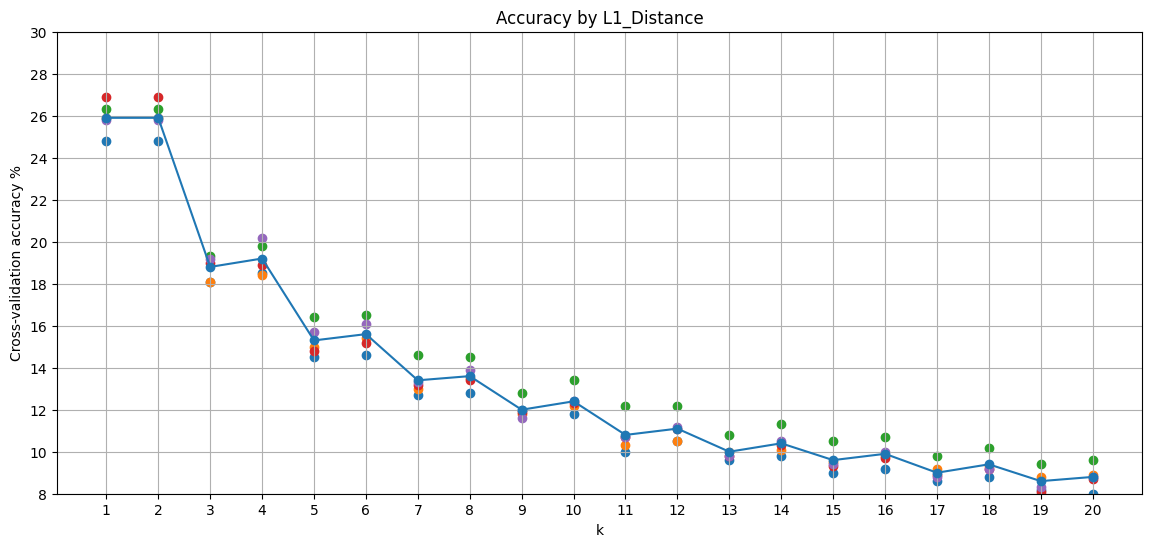

In [ ]:
# Accuracy by L1_Distance
x_list = list(range(1, k_range+1))
plt.figure(figsize=(14, 6))

for fold in accuracies:
  y_list = [round(acc*100, 1) for acc in fold[0]] # fold[0] = l1_accurracy
  plt.scatter(x_list, y_list)
#calculate equation for quadratic trendline
arr = []
for i in range(k_range):
  arr.append([fold[0][i] for fold in accuracies])
trend = [round(np.mean(a)*100,1) for a in arr]
plt.errorbar(x_list, trend,fmt='-o')

plt.title('Accuracy by L1_Distance')
plt.xticks(x_list)
plt.yticks(list(range(8, 31, 2)))
plt.grid(True)
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy %')
plt.ylim([8, 30])

plt.show()

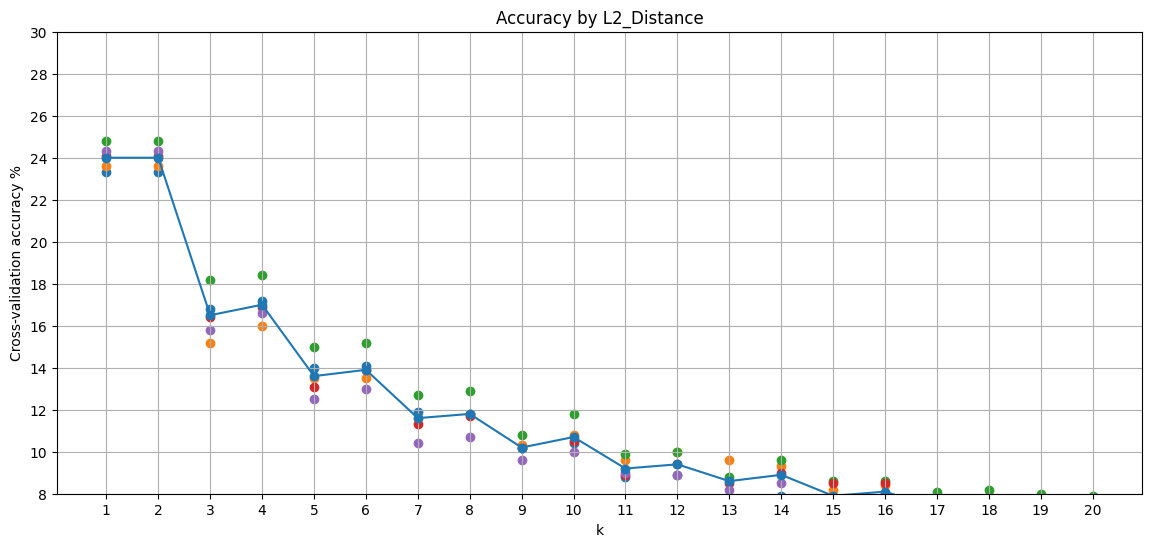

In [ ]:
# Accuracy by L2_Distance
x_list = list(range(1, k_range+1))
plt.figure(figsize=(14, 6))

for fold in accuracies:
  y_list = [round(acc*100, 1) for acc in fold[1]] # fold[1] = l2_accurracy
  plt.scatter(x_list, y_list)
#calculate equation for quadratic trendline
arr = []
for i in range(k_range):
  arr.append([fold[1][i] for fold in accuracies])
trend = [round(np.mean(a)*100,1) for a in arr]
plt.errorbar(x_list, trend,fmt='-o')

plt.title('Accuracy by L2_Distance')
plt.xticks(x_list)
plt.yticks(list(range(8, 31, 2)))
plt.grid(True)
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy %')
plt.ylim([8, 30])

plt.show()